# Import packages

Install instructions

* pipenv install
* pipenv run python -m spacy download es_core_news_lg

In [1]:
import pandas as pd
import json

# Setup the project
* Load spacy model for lemmatization
* Load nltk stopwords

In [2]:
import spacy

# Load the medium-sized Spanish model
nlp = spacy.load('es_core_news_lg')

In [3]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stop words for various languages
nltk.download('stopwords')

# Get stop words for Spanish
spanish_stop_words = stopwords.words('spanish')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* print out some stop words

In [4]:
print(spanish_stop_words[0:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


* extend stop words

In [5]:
type(spanish_stop_words[0])

str

In [6]:
spanish_stop_words.extend([
"mas",
"sino",
"esten",
"haber",
"hecho",
"si",
"cuya",
"siendo",
"hacen",
"unas",
"unos",
"sido",
"estan",
"ser",
"cuyo",
"hacer",
"poder",
"tener"
])

# Load the data

In [7]:

def load_json_from_path(file_path):
    """
    Load JSON data from a file path.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The JSON data loaded from the file.
    """
    with open(file_path, 'r', encoding="utf8") as file:
        json_data = json.load(file)
    return json_data



In [8]:
a1 = load_json_from_path('./data/article1.json')

* Data description

Each article contains an **title**, an **url** and the **content**. Each paragraph is separated as an item inside content

In [9]:
a1[0]

{'title': 'Petro y la lucha de clases / Columna de Felipe López Caballero',
 'url': 'https://www.eltiempo.com/politica/gobierno/petro-y-la-lucha-de-clases-columna-de-felipe-lopez-caballero-3333631',
 'content': ['La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  '2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  '3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores internacionales, pero la otra 

# Data cleaning
* Remove special characters
* Remove stop words
* Apply lemmatization

In [10]:
import re
from unidecode import unidecode

def preprocess_text(text):
    
    text = unidecode(text) # Remove accents 
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) # Remove punctuation and convert to lowercase

    return text

def remove_stop_words(text, custom_stop_words):
    """
    Remove custom stop words from the input text.

    Args:
        text (str): Input text.
        custom_stop_words (list): List of custom stop words to be removed.

    Returns:
        str: Text with custom stop words removed.
    """
    stop_words = set(custom_stop_words)
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def lemmatize(text):
    # Process the text
    doc = nlp(text)
    # Extract the lemma for each token in the text
    lemmas = [token.lemma_ for token in doc]
    return lemmas

* Load all articles in a single dataset

In [11]:
documents = []
documents.extend(a1[0]['content'])
documents.extend(a1[1]['content'])
documents.extend(a1[2]['content'])

* Apply cleaning

In [12]:
documents = [remove_stop_words(preprocess_text(' '.join(lemmatize(d))),spanish_stop_words) for d in documents]

* Data after cleaning

In [13]:
documents[0:3]

['explicacion narrativa petro red social crear segun colombia gobernado ano elite corrupto interesado solamente enriquecer perpetuar',
 'petro llegar primero presidente izquierda preocupacion pobre justicia social',
 'dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio']

# Modeling

Create a Count Vectorizer for create a word dictionary

In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=spanish_stop_words)

# Fit and transform the documents
X = vectorizer.fit_transform(documents)


In [15]:
vectorizer.get_feature_names_out()[0:5]

array(['abrir', 'abstracto', 'acabar', 'acertado', 'aclarar'],
      dtype=object)

In [53]:
def generate_ngrams(text, n):
    words = text.split()
    ngrams = []
    step = n-1
    for i in range(0,len(words) - n + 1,1):
        ngrams.append(' '.join(words[i:i + n]))
    return ngrams

In [42]:
list(range(0,5,2))

[0, 2, 4]

## Analyzing Contextual Word Relationships Using a Two-Word Window

* Create word pair relationships

In [44]:
docs_pairs = []

# Generate pairs after removing stop words for each document
docs_pairs.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),2)])

print(docs_pairs[0:3])

['explicacion narrativa', 'narrativa petro', 'petro red']


In [35]:
encoding = vectorizer.transform(docs_pairs).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [36]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            32
presidente       17
constitucion     14
gobierno         12
deber            12
campana          11
constituyente    10
gustavo          10
colombia         10
razon             9
izquierda         8
dtype: int64

In [37]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,gobierno,deber,campana,constituyente,gustavo,colombia,razon,izquierda
petro,0,0,0,0,0,1,0,5,0,1,0
presidente,0,0,0,0,0,0,0,3,0,0,2
constitucion,0,0,0,0,2,0,0,0,0,0,0
gobierno,0,0,0,0,1,0,0,0,0,0,0
deber,0,0,2,1,0,0,1,0,0,0,0
campana,1,0,0,0,0,0,0,0,0,0,0
constituyente,0,0,0,0,1,0,0,0,0,0,0
gustavo,5,3,0,0,0,0,0,0,0,0,0
colombia,0,0,0,0,0,0,0,0,0,0,0
razon,1,0,0,0,0,0,0,0,0,0,0


In [38]:
encoding = vectorizer.transform(docs_pairs).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

## Analyzing Contextual Word Relationships Using a Three-Word Window

In [54]:
docs_group = []

# Generate pairs after removing stop words for each document
docs_group.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),3)])

print(docs_group[0:3])

['explicacion narrativa petro', 'narrativa petro red', 'petro red social']


* Calculating co-occurences

In [55]:
encoding = vectorizer.transform(docs_group).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [56]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            92
presidente       50
constitucion     42
deber            34
gobierno         34
campana          32
constituyente    30
gustavo          28
colombia         26
razon            26
pais             24
dtype: int64

In [57]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,deber,gobierno,campana,constituyente,gustavo,colombia,razon,pais
petro,0,5,0,0,0,3,0,9,0,3,0
presidente,5,0,0,0,0,0,1,6,0,0,0
constitucion,0,0,0,4,0,0,0,1,0,0,0
deber,0,0,4,0,2,0,2,0,0,0,0
gobierno,0,0,0,2,0,0,0,0,1,0,0
campana,3,0,0,0,0,0,0,0,0,0,0
constituyente,0,1,0,2,0,0,0,0,0,0,0
gustavo,9,6,1,0,0,0,0,0,0,0,0
colombia,0,0,0,0,1,0,0,0,0,0,0
razon,3,0,0,0,0,0,0,0,0,0,0


## Analyzing Contextual Word Relationships Using a Five-Word Window

In [58]:
docs_group = []

# Generate pairs after removing stop words for each document
docs_group.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),5)])

print(docs_group[0:3])

['explicacion narrativa petro red social', 'narrativa petro red social crear', 'petro red social crear segun']


In [59]:
encoding = vectorizer.transform(docs_group).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [60]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            272
presidente       156
constitucion     140
deber            107
gobierno         100
constituyente     96
gustavo           88
pais              80
publico           80
campana           80
problema          80
dtype: int64

In [61]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,deber,gobierno,constituyente,gustavo,pais,publico,campana,problema
petro,0,15,2,0,0,0,17,3,2,6,11
presidente,15,0,0,0,0,3,12,0,0,0,2
constitucion,2,0,0,9,3,1,3,0,0,0,0
deber,0,0,9,0,5,4,0,0,0,0,0
gobierno,0,0,3,5,0,0,0,0,0,0,0
constituyente,0,3,1,4,0,0,0,0,0,0,0
gustavo,17,12,3,0,0,0,0,2,1,0,0
pais,3,0,0,0,0,0,2,0,3,0,8
publico,2,0,0,0,0,0,1,3,0,0,2
campana,6,0,0,0,0,0,0,0,0,0,0


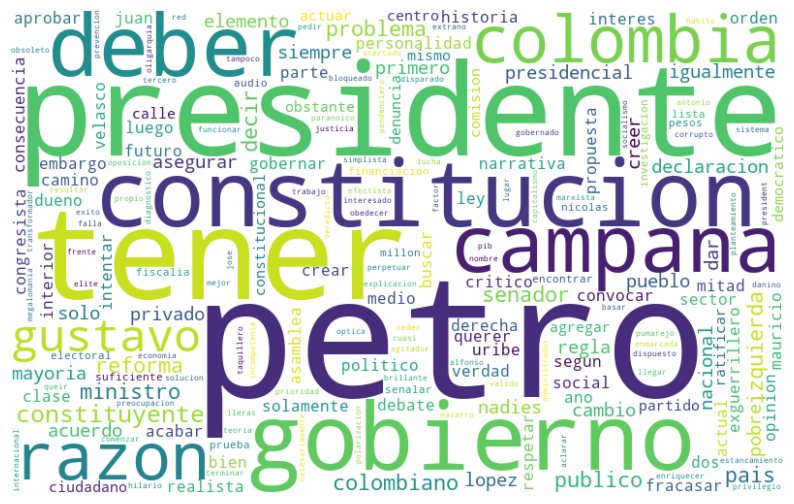

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Example raw text
raw_text = ' '.join(documents)

# Function to preprocess and compute word frequencies
def calculate_frequencies(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = text.split()
    # Calculate frequencies
    frequencies = Counter(words)
    return frequencies

# Calculate frequencies
word_frequencies = calculate_frequencies(raw_text)

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()
